In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

In [26]:
# Load dataset
file_path = "./Online Retail.xlsx"
df = pd.read_excel(file_path)

In [27]:
# Display basic info
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [28]:
# Display first few rows
print("\nFirst Few Rows:")
print(df.head())


First Few Rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [35]:
# Data Cleaning
df.dropna(inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[df['TotalPrice'] > 0]

In [36]:
# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
            Quantity                    InvoiceDate      UnitPrice  \
count  397884.000000                         397884  397884.000000   
mean       12.988238  2011-07-10 23:41:23.511023360       3.116488   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 14:39:00       1.950000   
75%        12.000000            2011-10-20 14:33:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       179.331775                            NaN      22.097877   

          CustomerID     TotalPrice  
count  397884.000000  397884.000000  
mean    15294.423453      22.397000  
min     12346.000000       0.001000  
25%     13969.000000       4.680000  
50%     15159.000000      11.800000  
75%     16795.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.141560     309.071041  


In [39]:
# Compute Recency, Frequency, and Monetary (RFM) features
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
})

rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)

# Log transformation to reduce skewness
rfm_log = np.log1p(rfm)

In [40]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [43]:
# PCA Transformation (Reducing Dimensions)
pca = PCA(n_components=3, random_state=0)
pca_result = pca.fit_transform(rfm_scaled)
# Explained Variance
print(f'The explained variance ratio: {pca.explained_variance_ratio_}')

The explained variance ratio: [0.72458515 0.19684999 0.07856486]


In [44]:
# Apply K-Means on PCA-reduced data
optimal_k = 4  # Choose based on Elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(pca_result)

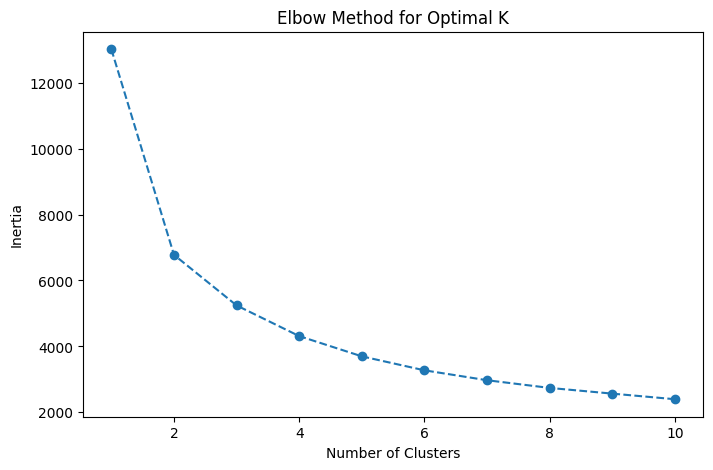

In [45]:
# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

Text(0.5, 0.92, 'PCA (3D Visualization)')

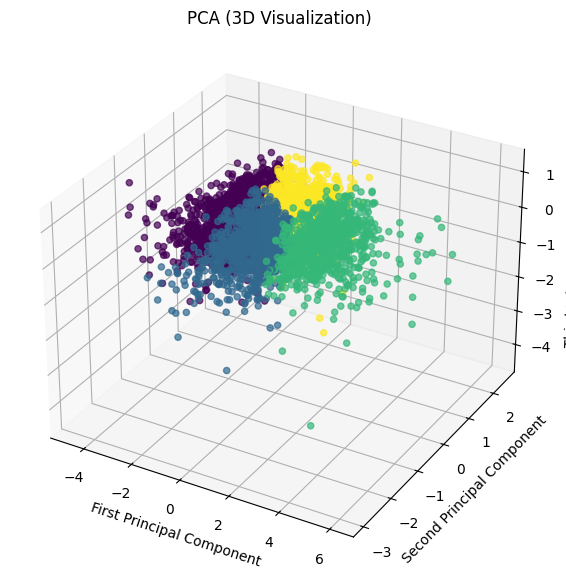

In [46]:

# Visualizing in 3D (First 3 Principal Components)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=labels, cmap='viridis', alpha=0.7)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.set_title('PCA (3D Visualization)')

In [47]:
# Adding legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

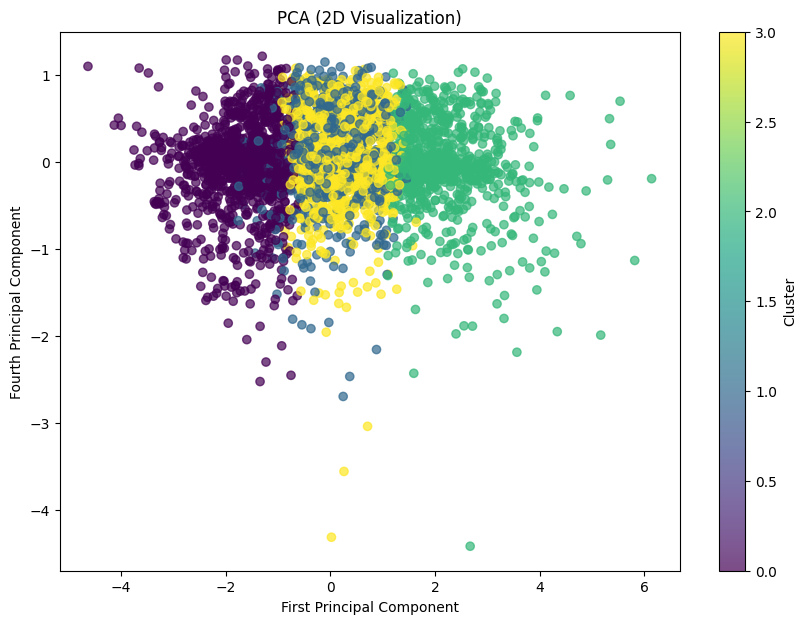

In [49]:

# Visualizing in 2D (First vs. Fourth Principal Component)
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 2], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Fourth Principal Component')
plt.title('PCA (2D Visualization)')
plt.colorbar(label="Cluster")
plt.show()

In [50]:
# Adding cluster labels to the original dataset
rfm['Cluster'] = labels

In [51]:

# Display cluster statistics
print("\nCluster Statistics:")
print(rfm.groupby('Cluster').mean())


Cluster Statistics:
            Recency   Frequency     Monetary
Cluster                                     
0        185.290487   14.968773   298.591097
1         19.894495   38.740826   612.062455
2         12.960829  282.894009  7042.565680
3         96.380016   80.211302  1518.085579
